In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from sklearn.decomposition import PCA

In [3]:
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 1
	elif location == "top_right":
		return (imgid - 1) * 4 + 2
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 3
	else:
		raise ValueError("Invalid location: {}".format(location))

# example
print(img_info_to_part_id("img01.bmp", "top_left"))
print(img_info_to_part_id("img01.bmp", "bottom_left"))
print(img_info_to_part_id("img01.bmp", "top_right"))
print(img_info_to_part_id("img01.bmp", "bottom_right"))
print()
print(img_info_to_part_id("img02.bmp", "top_left"))
print(img_info_to_part_id("img02.bmp", "bottom_left"))
print(img_info_to_part_id("img02.bmp", "top_right"))
print(img_info_to_part_id("img02.bmp", "bottom_right"))


def part_id_to_img_info(part_id):
	pid_copy = part_id
	while pid_copy % 4 != 0:
		pid_copy -= 1
	imgnum = pid_copy // 4 +1 
	imgnum = "{:02d}".format(imgnum)

	if part_id % 4 == 0:
		location = "top_left"
	elif part_id % 4 == 1:
		location = "bottom_left"
	elif part_id % 4 == 2:
		location = "top_right"
	elif part_id % 4 == 3:
		location = "bottom_right"
	else:
		raise ValueError("Invalid part ID: {}".format(part_id))

	return imgnum, location

# example
print(part_id_to_img_info(0))
print(part_id_to_img_info(1))
print(part_id_to_img_info(2))
print(part_id_to_img_info(3))
print()
print(part_id_to_img_info(4))
print(part_id_to_img_info(5))
print(part_id_to_img_info(6))
print(part_id_to_img_info(7))

cartella_immagini = {
	'originals': '../Processed dataset/df/',
	'rot&crop': '../Processed dataset/df new/',
	# Altre associazioni possibili
}

def genera_percorso_immagine(part_id, which_ones="originals",option="seg"):	
	imgnum, location = part_id_to_img_info(part_id)
	real_option = option
	if option=="seg":
		real_option = "segmented"
	else:
		real_option = "labeled"

	nome_immagine = f"img{imgnum}.bmp_{location}_{real_option}.png"
	return os.path.join(cartella_immagini[which_ones], nome_immagine)

# Utilizzo della funzione
print(genera_percorso_immagine(0, "originals"))
print(genera_percorso_immagine(1, "originals"))
print(genera_percorso_immagine(2, "originals"))
print(genera_percorso_immagine(3, "originals"))

0
1
2
3

4
5
6
7
('01', 'top_left')
('01', 'bottom_left')
('01', 'top_right')
('01', 'bottom_right')

('02', 'top_left')
('02', 'bottom_left')
('02', 'top_right')
('02', 'bottom_right')
../Processed dataset/df/img01.bmp_top_left_segmented.png
../Processed dataset/df/img01.bmp_bottom_left_segmented.png
../Processed dataset/df/img01.bmp_top_right_segmented.png
../Processed dataset/df/img01.bmp_bottom_right_segmented.png


In [6]:
# Loading a CSV file into a DataFrame
df = pd.read_csv('../Processed dataset/df.csv')
df_voids = pd.read_csv('../Processed dataset/df_voids.csv')
df_parts = pd.read_csv('../Processed dataset/df_parts.csv')

df_new = pd.read_csv('../Processed dataset/df_new.csv')
df_new_voids = pd.read_csv('../Processed dataset/df_new_voids.csv')
df_new_parts = pd.read_csv('../Processed dataset/df_new_parts.csv')

print(df_parts.shape)
print(df_new_parts.shape)
print()
print(df_voids.shape)
print(df_new_voids.shape)
print()
print(df.shape)
print(df_new.shape)

(40, 15)
(40, 18)

(1754, 15)
(1746, 18)

(1794, 15)
(1786, 18)


In [16]:
def plot_object(part_id):
	plt.figure(figsize=(8, 10))

	plt.subplot(1, 2, 1)
	# plt.subplot(1, 2, 2)
	# plt.subplot(1, 4, 2)
	img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","lab"))
	height, width = img_new.shape[:2]
	zoom_factor = 0.8 
	zoomed_width = width * zoom_factor
	zoomed_height = height * zoom_factor
	x_center = width // 2
	y_center = height // 2
	x1 = max(0, x_center - zoomed_width // 2)
	x2 = min(width, x_center + zoomed_width // 2)
	y1 = max(0, y_center - zoomed_height // 2)
	y2 = min(height, y_center + zoomed_height // 2)
	plt.imshow(img_new, cmap="gray")
	plt.axis('off')
	plt.xlim(x1, x2)
	plt.ylim(y2, y1)
	plt.title(f"img new (part_id {part_id}, nvoids={df_new_parts.iloc[part_id]['Num_voids']})")

	plt.subplot(1, 2, 2)
	# plt.subplot(1, 4, 4)
	img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","seg"))
	plt.imshow(img_new,cmap="gray")
	plt.title(f"img new (part_id {part_id}, nvoids={df_new_parts.iloc[part_id]['Num_voids']})")
	plt.axis("off")

	plt.tight_layout()
	plt.show()

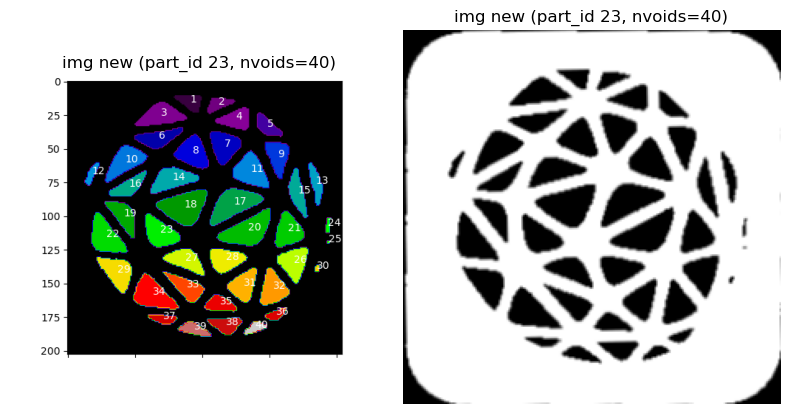

In [21]:
plot_object(23)

In [10]:
def plot_column(dataframe,colonna):
	plt.plot(dataframe[colonna])
	plt.title(colonna)
	plt.show()

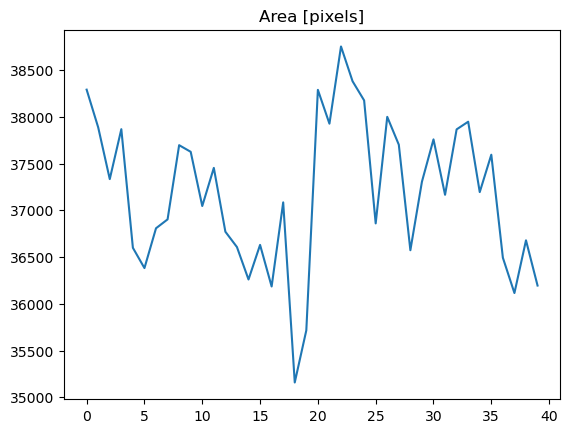

In [11]:
plot_column(df_new_parts,'Area [pixels]')